In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
from datetime import datetime
import concurrent.futures

# For better plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
warnings.filterwarnings('ignore')


In [2]:

# Define the function for running a single simulation outside of run_simulation
# 
def run_single_simulation(params, methods, continuous_treatment, misspecified, seed):
    """
    Function to run a single simulation. This needs to be at the module level to be picklable.
    """
    from permutation_weighting.estimator import PW
    from examples.data_utils import (generate_kang_schafer_data, evaluate_ate_binary, 
                                    evaluate_dose_response_continuous)
    from external_methods import (compute_unweighted, compute_ipsw_logit, compute_ipsw_gbm, 
                                 compute_cbps_binary, compute_sbw_binary, compute_normal_linear_weights, 
                                 compute_np_cbps)
    
    rep, size = params
    local_seed = seed + rep
    
    # Generate data
    df = generate_kang_schafer_data(
        n=size, 
        seed=local_seed, 
        misspecified=misspecified,
        continuous_treatment=continuous_treatment
    )
    
    # Get feature columns based on misspecification
    if misspecified:
        feature_cols = [col for col in df.columns if col.endswith('_mis')]
    else:
        feature_cols = [col for col in df.columns if col.startswith('X') and not col.endswith('_mis')]
    
    x_features = df[feature_cols]
    
    # Results for this simulation
    sim_results = {}
    sim_timings = {}
    
    # Apply each method
    for method_name, method_func in methods.items():
        try:
            # Time the method
            start_time = time.time()
            
            # Get weights
            weights = method_func(df['A'].values, x_features)
            
            # Record execution time
            execution_time = time.time() - start_time
            sim_timings[method_name] = execution_time
            
            # Evaluate based on treatment type
            if continuous_treatment:
                # Evaluate dose-response for continuous treatment
                eval_result = evaluate_dose_response_continuous(df, weights)
                
                # Store results
                sim_results[method_name] = {
                    'integrated_bias': eval_result.get('integrated_bias', np.nan),
                    'integrated_rmse': eval_result.get('integrated_rmse', np.nan)
                }
            else:
                # Evaluate ATE for binary treatment - returns the error directly
                ate_error = evaluate_ate_binary(df, weights)
                
                # Store results
                sim_results[method_name] = {
                    'bias': abs(ate_error),
                    'rmse': ate_error**2,  # Will take sqrt later
                    'mae': abs(ate_error)
                }
            
        except Exception as e:
            # Just skip this method if it fails
            print(f"Error with method {method_name} for size {size}, rep {rep}: {e}")
            sim_results[method_name] = {}
            sim_timings[method_name] = np.nan
    
    return rep, size, sim_results, sim_timings

In [3]:
# Updated run_simulation function with parallel processing
def run_simulation(n_replications=50, sample_sizes=None, misspecified=False, continuous_treatment=False,
                  nn_configs=None, methods_to_include=None, output_dir=None, seed=42, verbose=True,
                  max_workers=8):
    """
    Run simulation for both binary and continuous treatment methods with parallel processing
    
    Parameters:
    -----------
    n_replications: int
        Number of simulation replications
    sample_sizes: list
        List of sample sizes to test (defaults to [500, 1000, 2000, 5000])
    misspecified: bool
        Whether to use misspecified covariates
    continuous_treatment: bool
        Whether to use continuous treatment
    nn_configs: dict, optional
        Neural network configurations
    methods_to_include: list, optional
        List of method names to include (defaults to all)
    output_dir: str, optional
        Directory to save results
    seed: int
        Random seed
    verbose: bool
        Whether to display progress information
    max_workers: int
        Maximum number of parallel workers
        
    Returns:
    --------
    tuple (raw_results, summary_results)
        Tuple containing raw results and summary statistics
    """
    from permutation_weighting.estimator import PW
    from examples.data_utils import (generate_kang_schafer_data, evaluate_ate_binary, 
                          evaluate_dose_response_continuous, create_output_dir)
    from external_methods import (compute_unweighted, compute_ipsw_logit, compute_ipsw_gbm, 
                                compute_cbps_binary, compute_sbw_binary, compute_normal_linear_weights, 
                                compute_np_cbps)
    from examples.plots import (plot_binary_simulation_results, plot_continuous_simulation_results, 
                      plot_execution_time, create_comparison_plots)
    
    np.random.seed(seed)
    
    # Set default sample sizes if not provided
    if sample_sizes is None:
        sample_sizes = [500, 1000, 2000, 5000]
    
    # Create output directory if provided
    if output_dir is None:
        output_dir = create_output_dir("comparison_results")
        if verbose:
            print(f"Results will be saved to: {output_dir}")
    else:
        os.makedirs(output_dir, exist_ok=True)
    
    # Define default neural network configurations if not provided
    if nn_configs is None:
        nn_configs = {
            'hidden_size': 64,
            'batch_size': 32,
            'epochs': 100,
            'learning_rate': 0.001,
            'alpha': 0.0001
        }
    
    # Define methods based on treatment type
    methods = {}
    
    # Core methods for both binary and continuous treatments
    methods['Unweighted'] = lambda a, x: compute_unweighted(a, x)
    
    methods['PW-GLM'] = lambda a, x: PW(
        a, x, 
        classifier='logit', 
        estimand='ATE',
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    methods['PW-Boosting'] = lambda a, x: PW(
        a, x, 
        classifier='boosting', 
        estimand='ATE',
        classifier_params={'n_estimators': 100, 'max_depth': 3},
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    # Add batch size for SGD-based trainers to utilize mini-batch processing
    batch_size = nn_configs.get('batch_size', 32)
    
    # SGD-based trainers with mini-batch optimization
    methods['PW-SGD-Logit'] = lambda a, x: PW(
        a, x, 
        classifier='logit', 
        estimand='ATE',
        use_sgd=True,
        classifier_params={
            'alpha': nn_configs.get('alpha', 0.0001),
            'max_iter': nn_configs.get('epochs', 100),
            'learning_rate': 'optimal'
        },
        num_replicates=50,
        estimand_params={'bootstrap': True},
        batch_size=batch_size  # Using batch size for mini-batch processing
    )['weights']
    
    methods['PW-Neural'] = lambda a, x: PW(
        a, x, 
        classifier='neural_net', 
        estimand='ATE',
        use_sgd=True,
        classifier_params={
            'hidden_layer_sizes': (nn_configs.get('hidden_size', 64),),
            'max_iter': nn_configs.get('epochs', 100),
            'batch_size': batch_size,  # Mini-batch size inside the model
            'learning_rate_init': nn_configs.get('learning_rate', 0.001)
        },
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    # Mini-batch permutation approach
    methods['PW-Batch-SGD'] = lambda a, x: PW(
        a, x, 
        classifier='logit', 
        estimand='ATE',
        use_sgd=True,
        batch_size=batch_size,  # This enables mini-batch permutation
        classifier_params={
            'alpha': nn_configs.get('alpha', 0.0001),
            'max_iter': nn_configs.get('epochs', 100),
            'learning_rate': 'optimal'
        },
        num_replicates=1,  # Only 1 replicate since permutation happens in batches
        estimand_params={'bootstrap': False}
    )['weights']
    
    # PyTorch-based trainers if available
    try:
        import torch
        
        methods['PW-Torch-MLP'] = lambda a, x: PW(
            a, x, 
            classifier='mlp', 
            estimand='ATE',
            use_torch=True,
            classifier_params={
                'hidden_dims': [nn_configs.get('hidden_size', 64), nn_configs.get('hidden_size', 64)//2],
                'epochs': nn_configs.get('epochs', 100),
                'batch_size': batch_size,  # Mini-batch size inside the model
                'learning_rate': nn_configs.get('learning_rate', 0.001)
            },
            num_replicates=50,
            estimand_params={'bootstrap': True}
        )['weights']
        
        methods['PW-Batch-Torch'] = lambda a, x: PW(
            a, x, 
            classifier='mlp', 
            estimand='ATE',
            use_torch=True,
            batch_size=batch_size,  # This enables mini-batch permutation
            classifier_params={
                'hidden_dims': [nn_configs.get('hidden_size', 64), nn_configs.get('hidden_size', 64)//2],
                'epochs': nn_configs.get('epochs', 100),
                'learning_rate': nn_configs.get('learning_rate', 0.001)
            },
            num_replicates=1,  # Only 1 replicate since permutation happens in batches
            estimand_params={'bootstrap': False}
        )['weights']
        
        if continuous_treatment:
            methods['PW-Torch-ResNet'] = lambda a, x: PW(
                a, x, 
                classifier='resnet', 
                estimand='ATE',
                use_torch=True,
                classifier_params={
                    'hidden_dim': nn_configs.get('hidden_size', 64),
                    'num_blocks': nn_configs.get('num_blocks', 2),
                    'epochs': nn_configs.get('epochs', 100),
                    'batch_size': batch_size,  # Mini-batch size inside the model
                    'learning_rate': nn_configs.get('learning_rate', 0.001)
                },
                num_replicates=50,
                estimand_params={'bootstrap': True}
            )['weights']
    except ImportError:
        if verbose:
            print("PyTorch not available, skipping PyTorch-based models")
    
    # Add treatment-specific methods
    if continuous_treatment:
        # Continuous treatment methods
        methods['IPSW-GLM'] = lambda a, x: compute_normal_linear_weights(a, x, misspecified)
        methods['npCBPS'] = lambda a, x: compute_np_cbps(a, x, misspecified)
    else:
        # Binary treatment methods
        methods['IPSW-GLM'] = lambda a, x: compute_ipsw_logit(a, x, misspecified)
        methods['IPSW-GBM'] = lambda a, x: compute_ipsw_gbm(a, x, misspecified)
        methods['CBPS'] = lambda a, x: compute_cbps_binary(a, x, misspecified)
        methods['SBW'] = lambda a, x: compute_sbw_binary(a, x, misspecified)
    
    # Filter methods if specified
    if methods_to_include is not None:
        methods = {k: v for k, v in methods.items() if k in methods_to_include}
    
    # Initialize metrics based on treatment type
    if continuous_treatment:
        metrics = ['integrated_bias', 'integrated_rmse']
    else:
        metrics = ['bias', 'rmse', 'mae']
    
    # Storage for raw and summary results
    raw_results = {
        method: {metric: {size: [] for size in sample_sizes} for metric in metrics} 
        for method in methods
    }
    
    # Storage for timing information
    timings = {size: {method: [] for method in methods} for size in sample_sizes}
    
    # Run simulations in parallel
    simulation_params = [(rep, size) for rep in range(n_replications) for size in sample_sizes]
    
    if verbose:
        print(f"Running {len(simulation_params)} simulations using up to {max_workers} workers...")
    
    # IMPORTANT: We have to use sequential processing instead of parallel
    # because lambda functions can't be pickled
    results = []
    for param in simulation_params:
        if verbose:
            rep, size = param
            print(f"Starting replication {rep+1} for sample size {size}")
        result = run_single_simulation(param, methods, continuous_treatment, misspecified, seed)
        results.append(result)
        
        if verbose:
            rep, size, _, _ = result
            print(f"Completed replication {rep+1} for sample size {size}")
    
    # Process results
    for rep, size, sim_results, sim_timings in results:
        # Store results
        for method_name, result in sim_results.items():
            for metric, value in result.items():
                if not np.isnan(value):
                    raw_results[method_name][metric][size].append(value)
        
        # Store timings
        for method_name, timing in sim_timings.items():
            if not np.isnan(timing):
                timings[size][method_name].append(timing)
    
    # Compute summary statistics
    summary = {}
    
    for method in methods:
        summary[method] = {}
        
        for metric in metrics:
            # For bias-type metrics, take mean
            summary[method][metric] = {
                size: np.mean(raw_results[method][metric][size]) 
                for size in sample_sizes 
                if raw_results[method][metric][size]
            }
            
            # Add standard error
            summary[method][f"{metric}_std"] = {
                size: np.std(raw_results[method][metric][size]) / np.sqrt(max(1, len(raw_results[method][metric][size]))) 
                for size in sample_sizes 
                if raw_results[method][metric][size]
            }
    
    # Take square root for RMSE if binary treatment
    if not continuous_treatment:
        for method in methods:
            for size in sample_sizes:
                if size in summary[method]['rmse']:
                    summary[method]['rmse'][size] = np.sqrt(summary[method]['rmse'][size])
                    if f'rmse_std' in summary[method] and size in summary[method]['rmse_std']:
                        summary[method]['rmse_std'][size] /= 2 * np.sqrt(summary[method]['rmse'][size])
    
    # Create plots
    if continuous_treatment:
        plot_continuous_simulation_results(summary, sample_sizes, output_dir=output_dir)
    else:
        plot_binary_simulation_results(summary, sample_sizes, output_dir=output_dir)
    
    # Create timing plot
    plot_execution_time(timings, sample_sizes, output_dir=output_dir)
    
    # Create combined comparison plot
    create_comparison_plots(summary, sample_sizes, continuous=continuous_treatment, output_dir=output_dir)
    
    # Save results
    results_file = os.path.join(output_dir, "simulation_results.npz")
    np.savez(
        results_file,
        raw_results=raw_results,
        summary=summary,
        timings=timings,
        treatment_type="continuous" if continuous_treatment else "binary",
        misspecified=misspecified,
        sample_sizes=sample_sizes,
        n_replications=n_replications
    )
    
    if verbose:
        print(f"Results saved to {results_file}")
    
    return raw_results, summary

Main results will be saved to: model_comparison_20250318_151149
Using sequential processing for simulations due to pickling limitations
PyTorch is available. Will include PyTorch models.

=== Running Simulation 1/4: Binary Treatment (Well-Specified) ===
Running 6 simulations using up to 8 workers...
Starting replication 1 for sample size 500
Completed replication 1 for sample size 500
Starting replication 1 for sample size 1000
Completed replication 1 for sample size 1000
Starting replication 1 for sample size 2000
Completed replication 1 for sample size 2000
Starting replication 2 for sample size 500
Completed replication 2 for sample size 500
Starting replication 2 for sample size 1000
Completed replication 2 for sample size 1000
Starting replication 2 for sample size 2000
Completed replication 2 for sample size 2000
Results saved to model_comparison_20250318_151149/binary_wellspec/simulation_results.npz
Simulation 1 complete. Results saved to model_comparison_20250318_151149/binary_

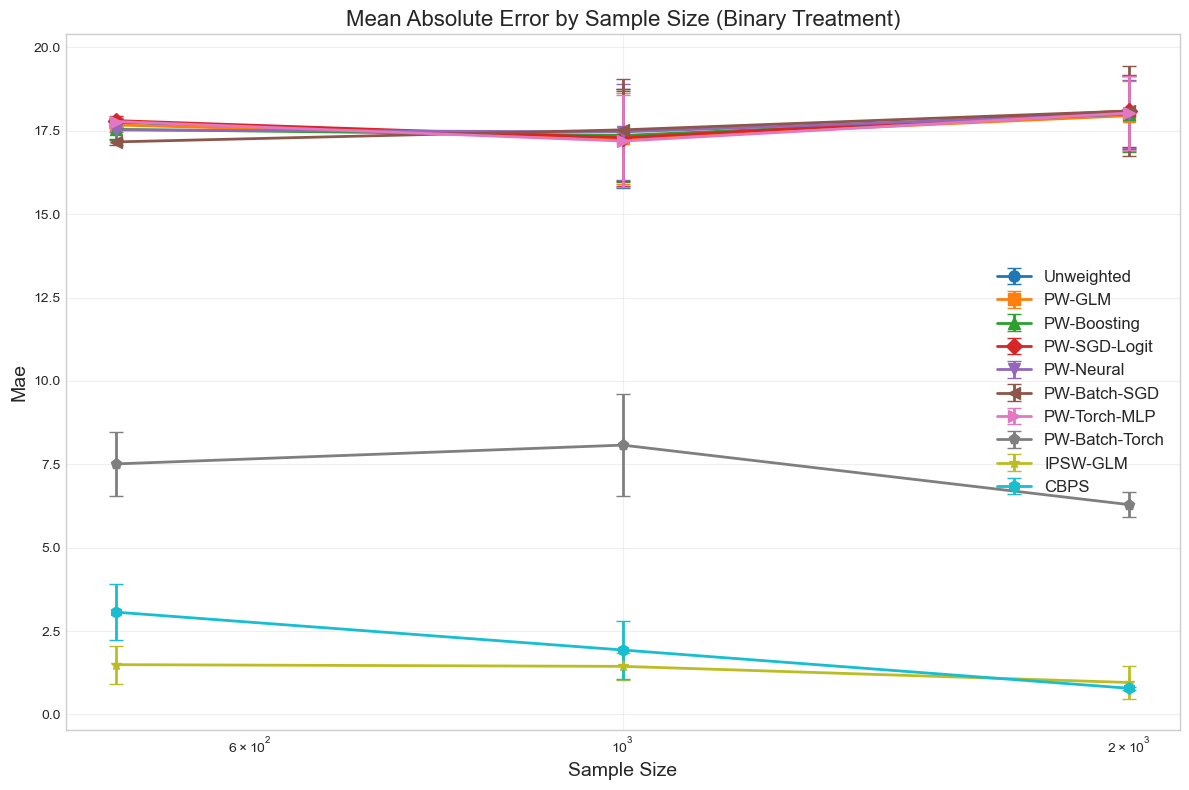

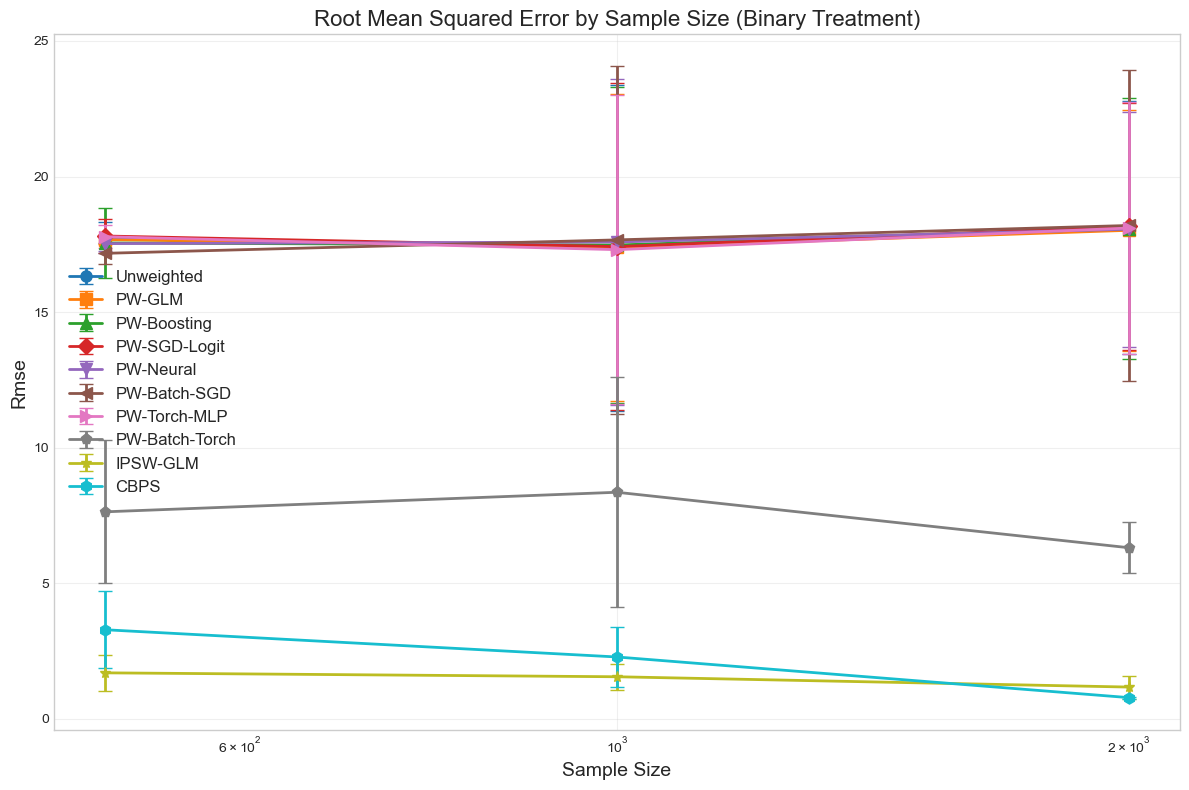

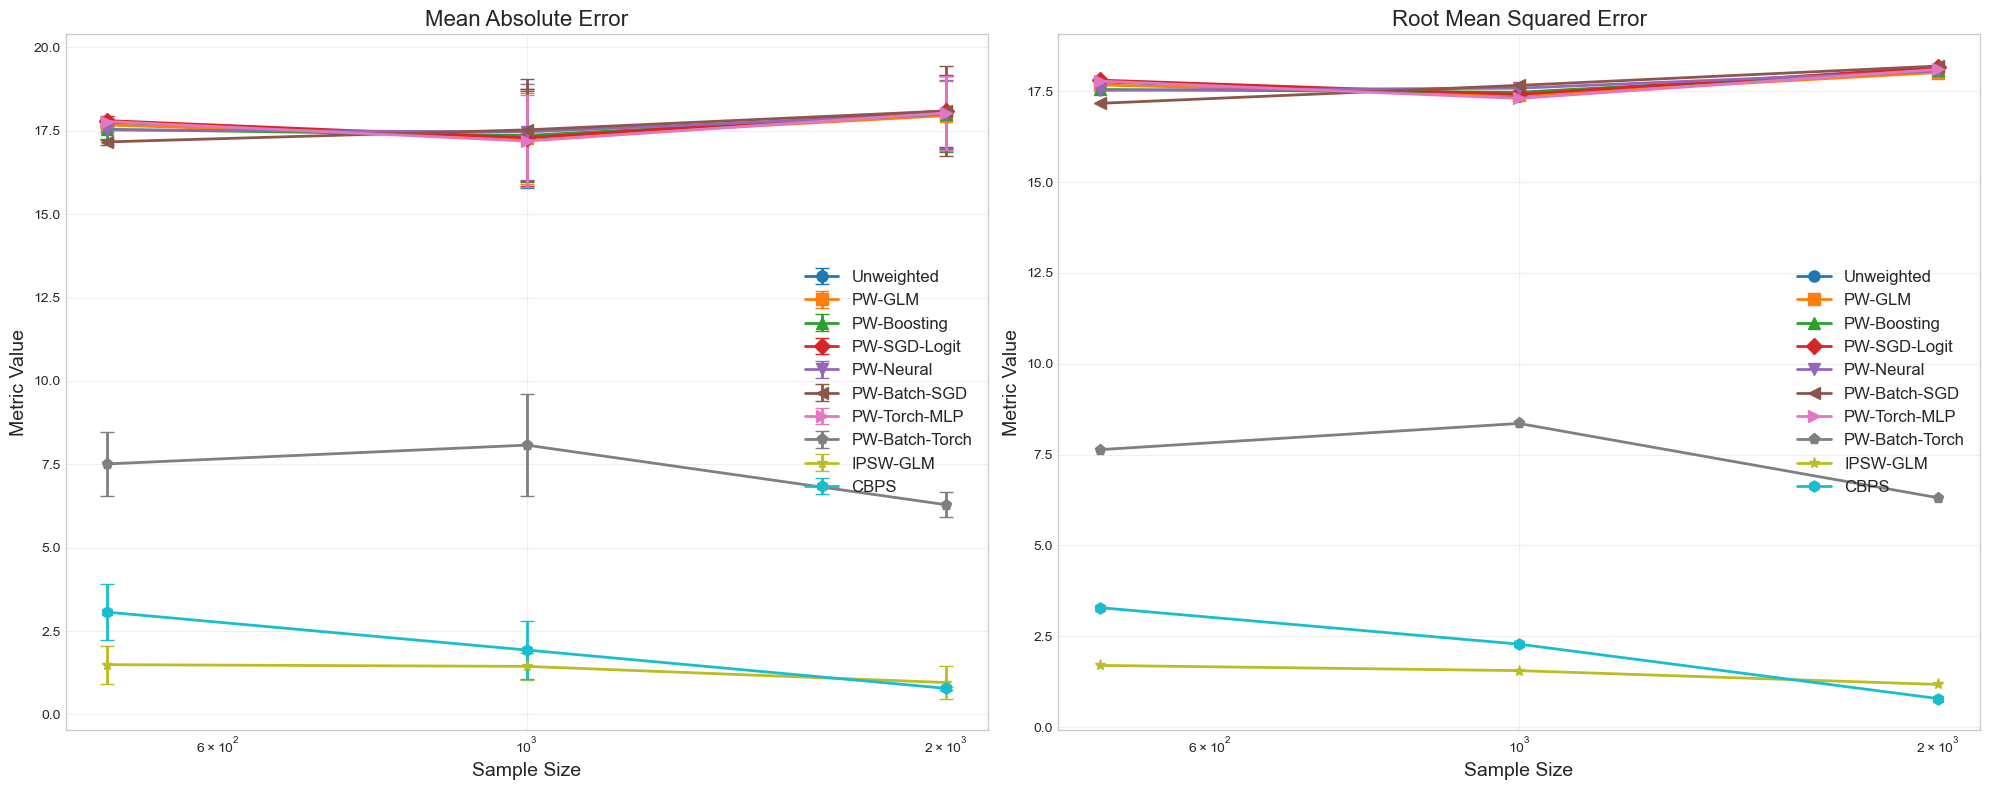

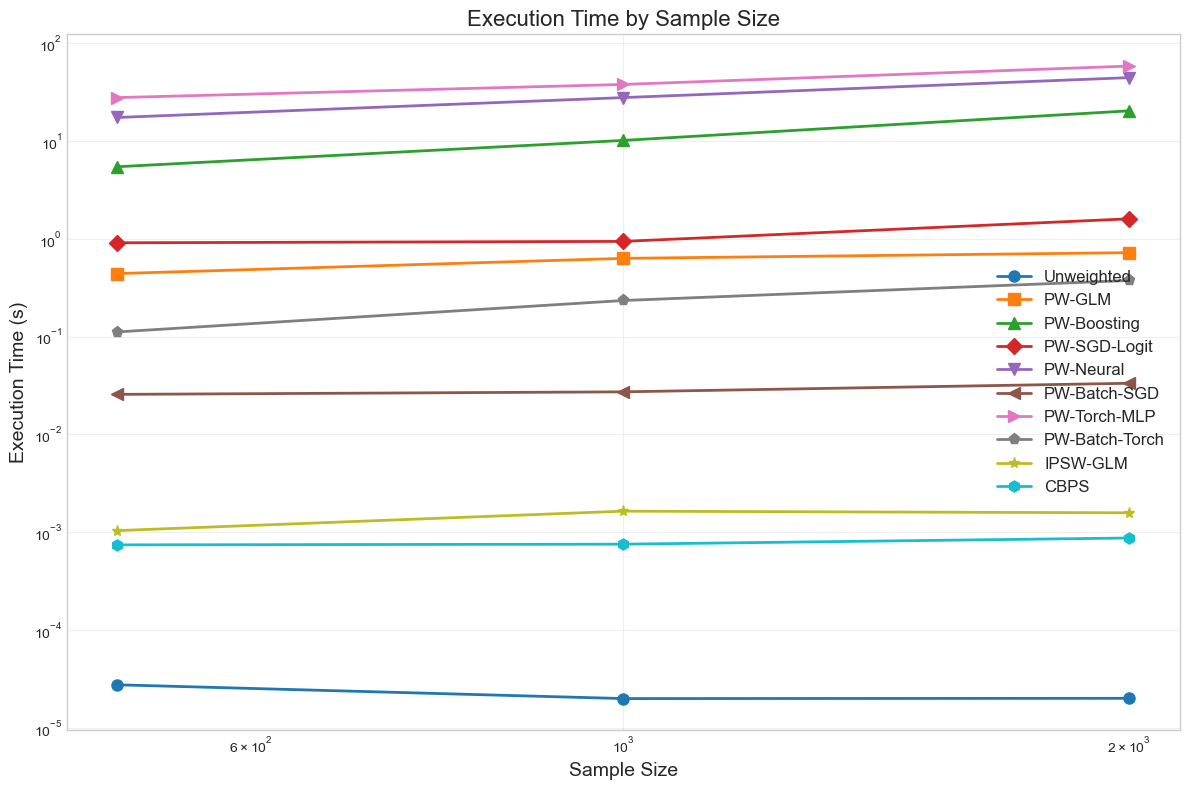

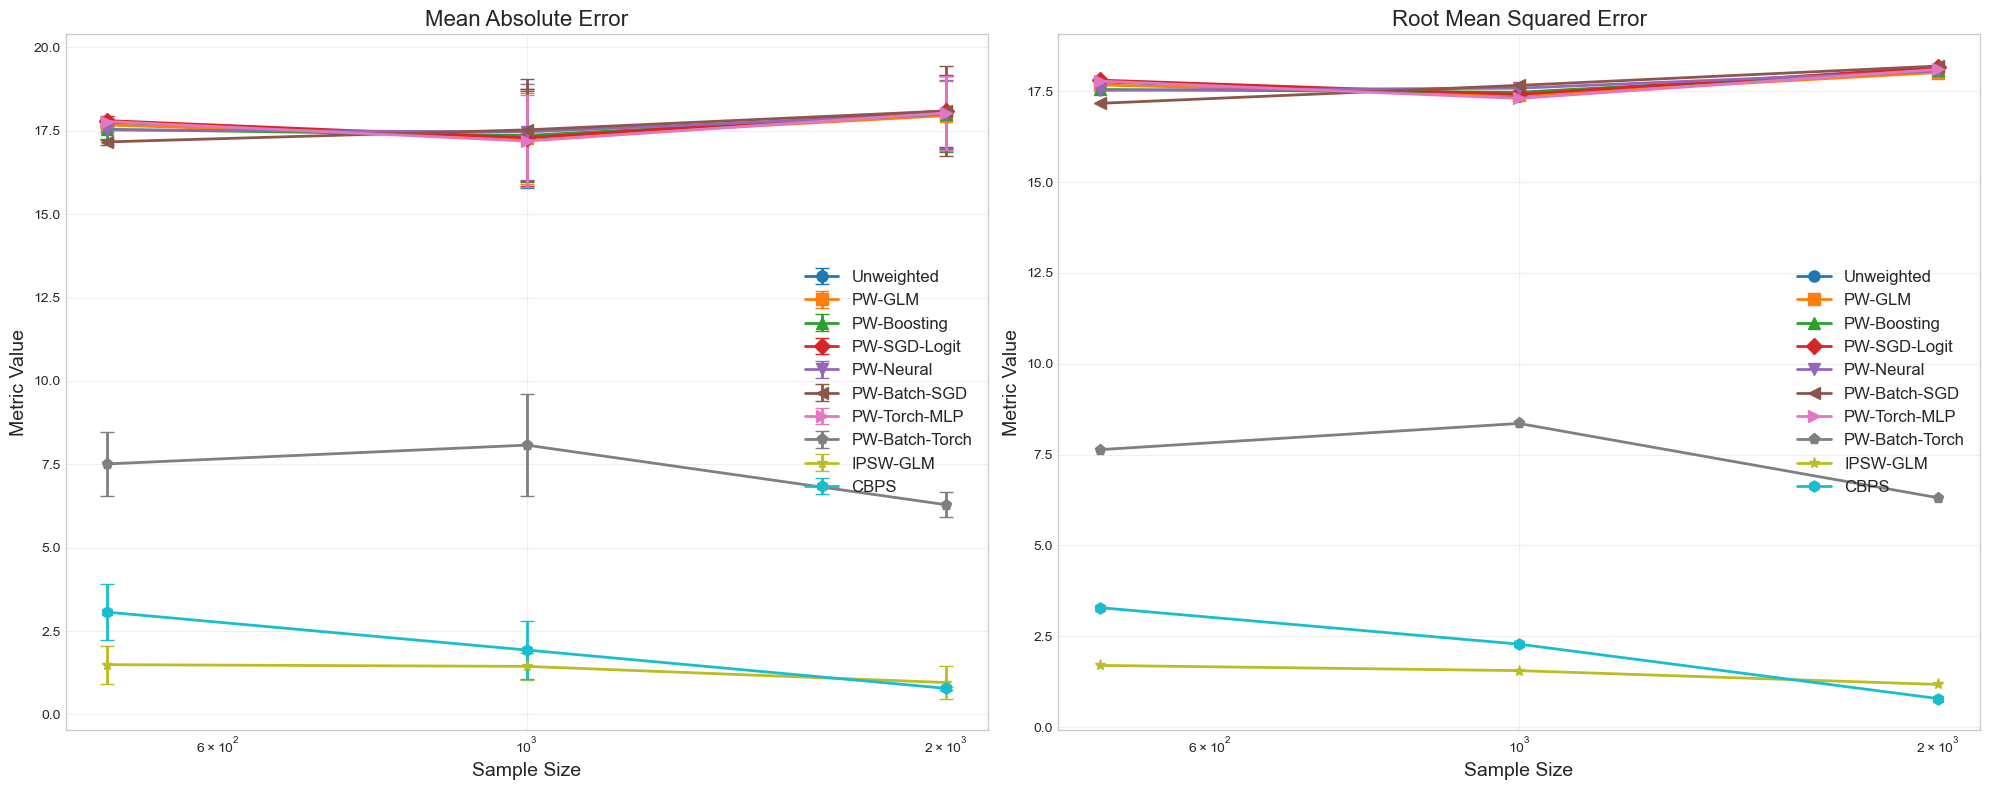

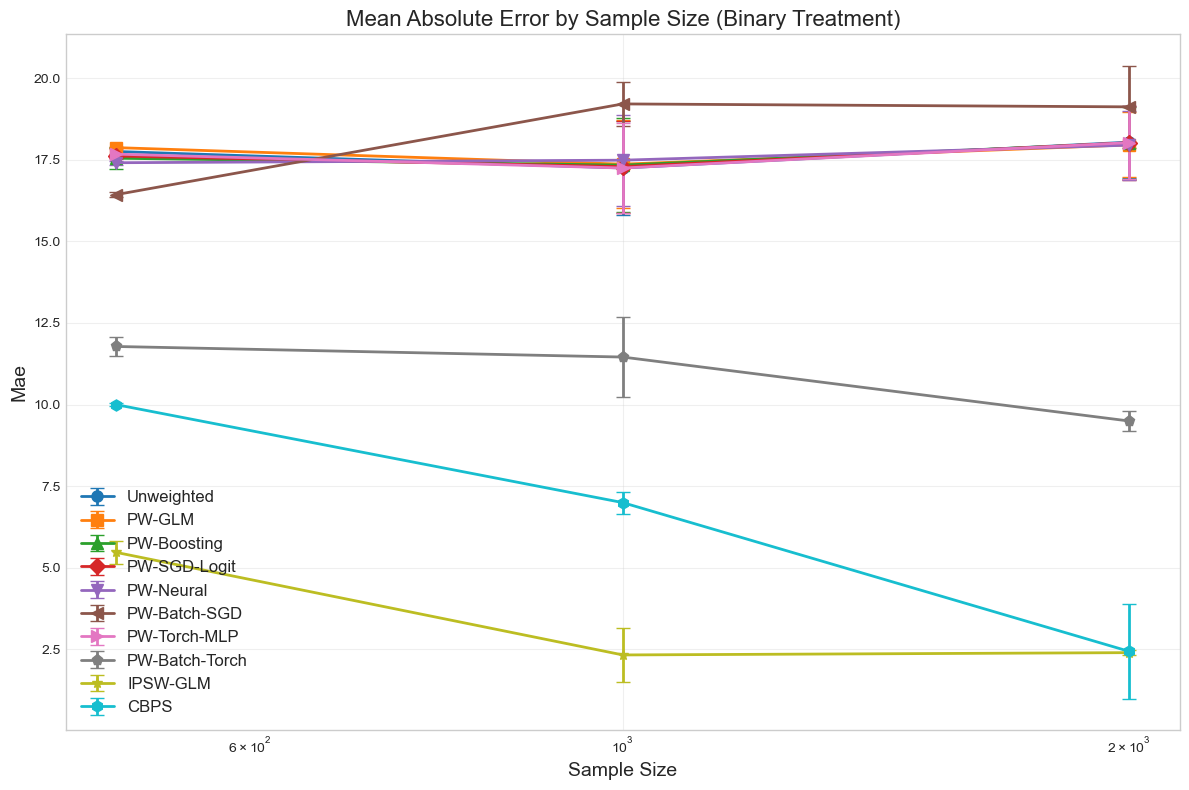

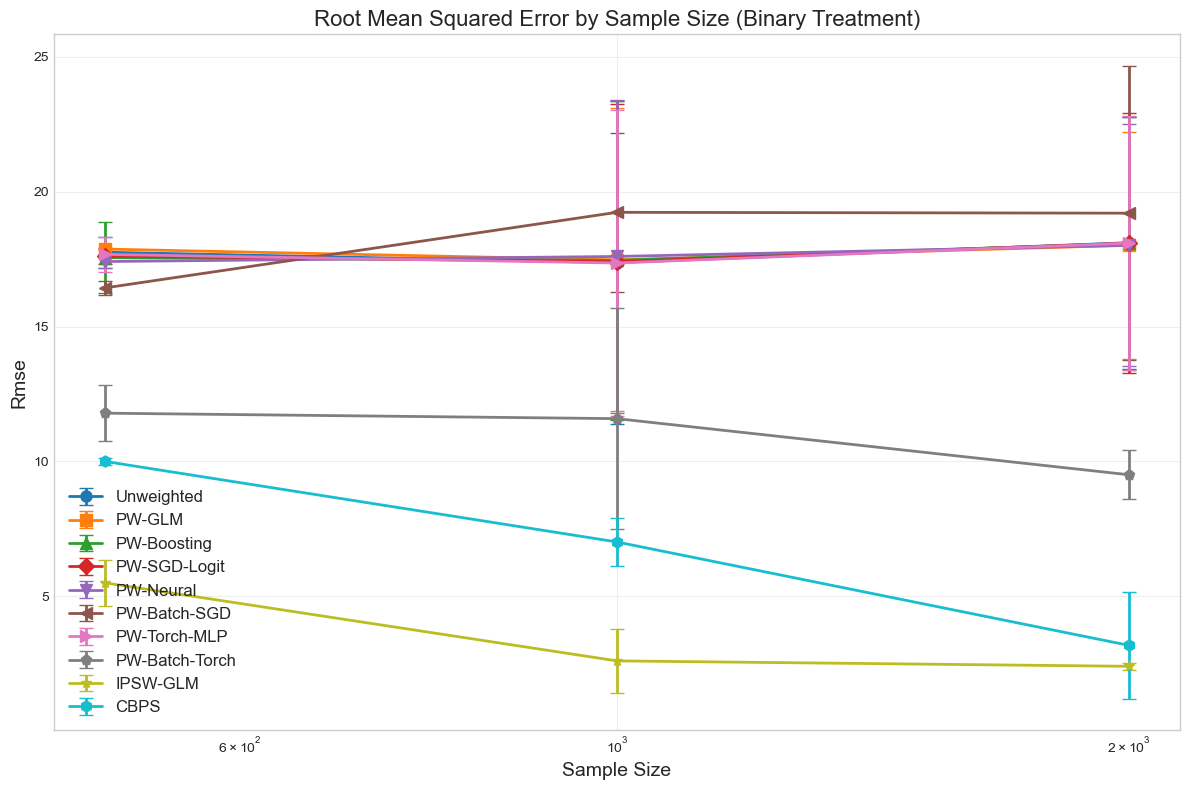

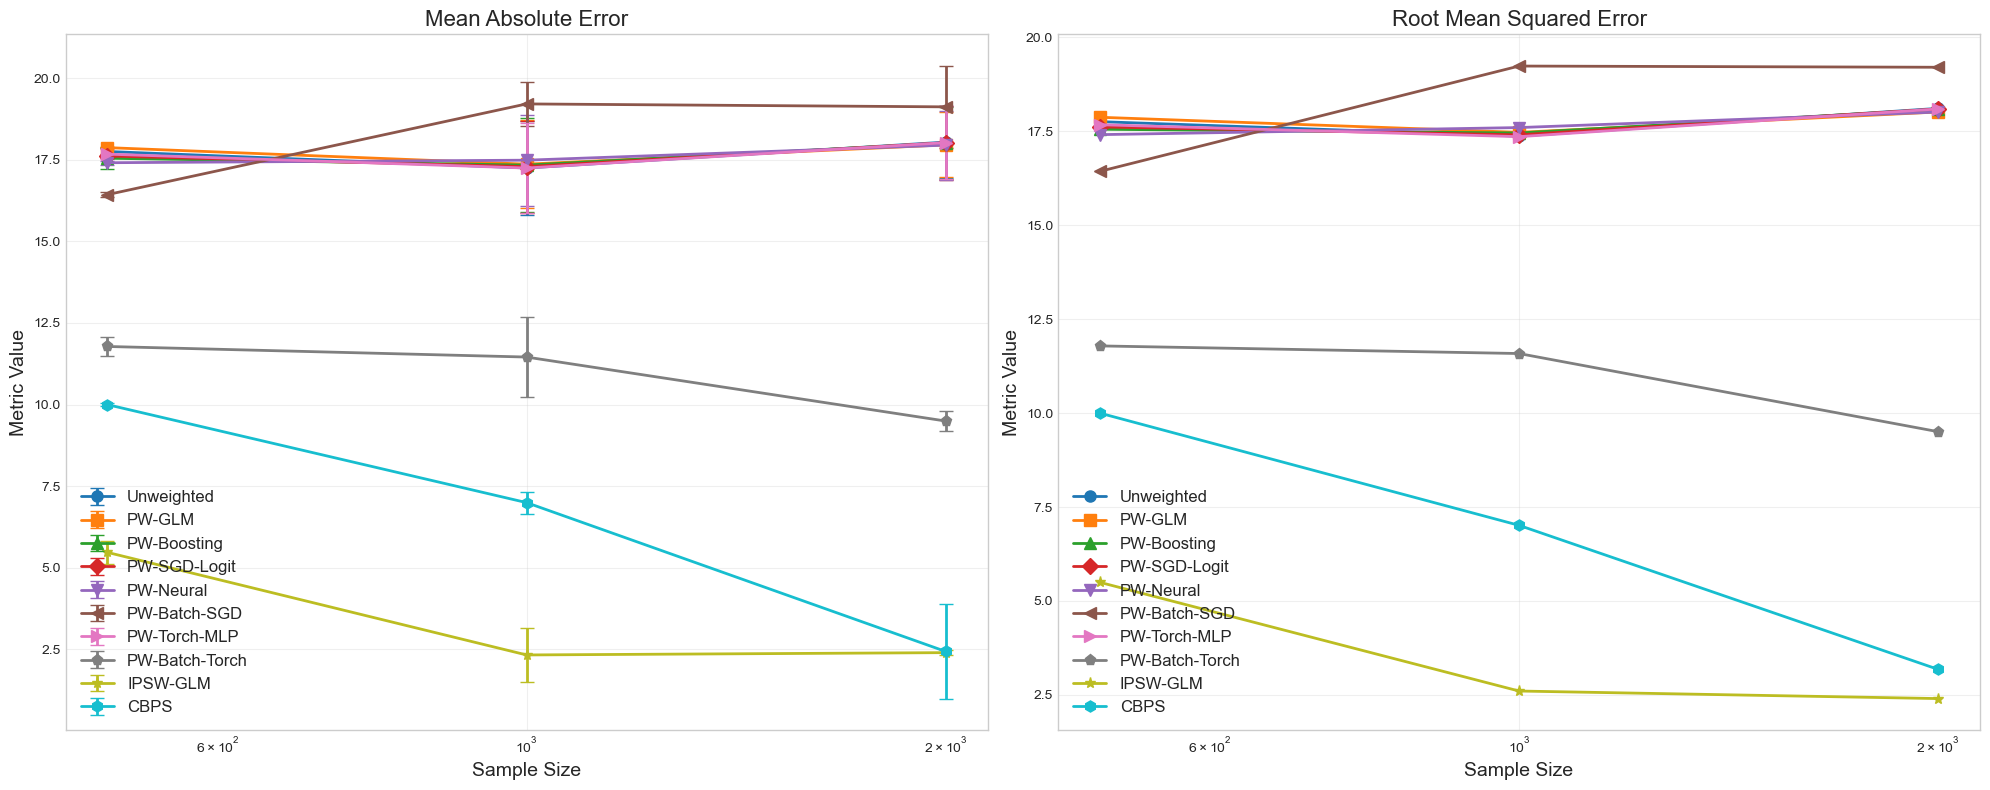

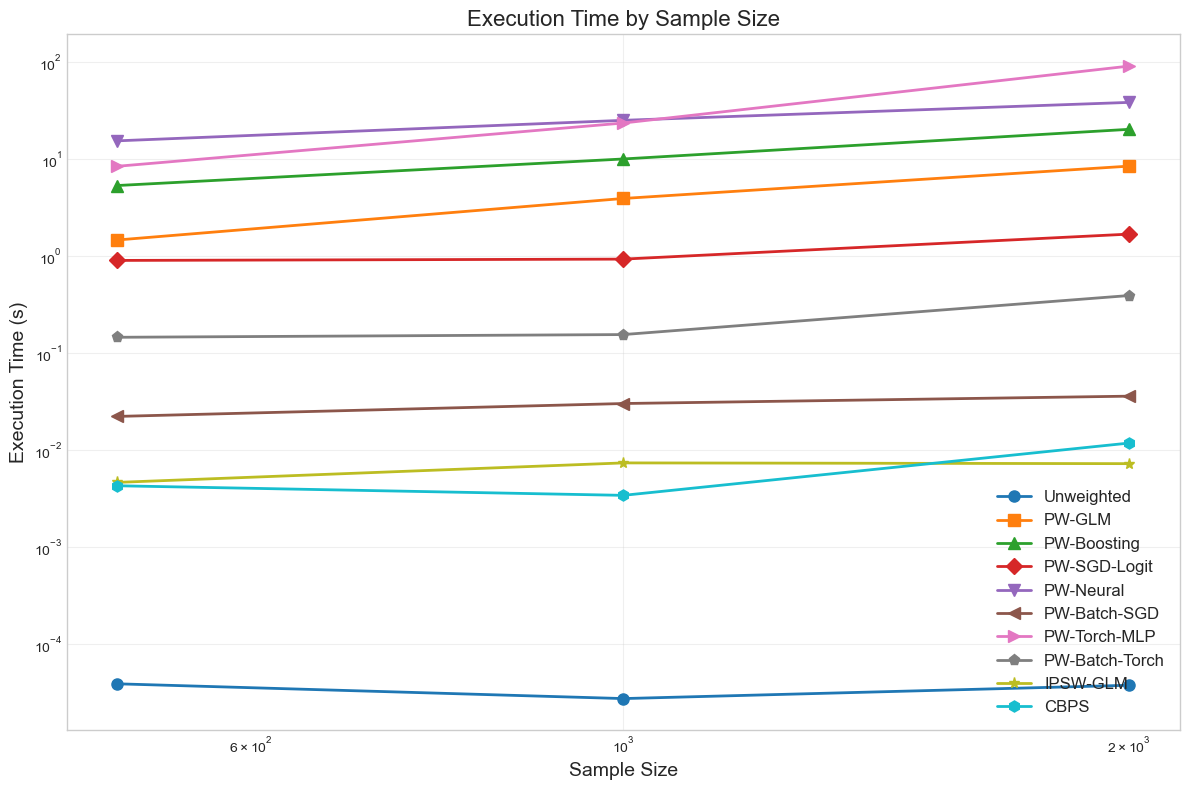

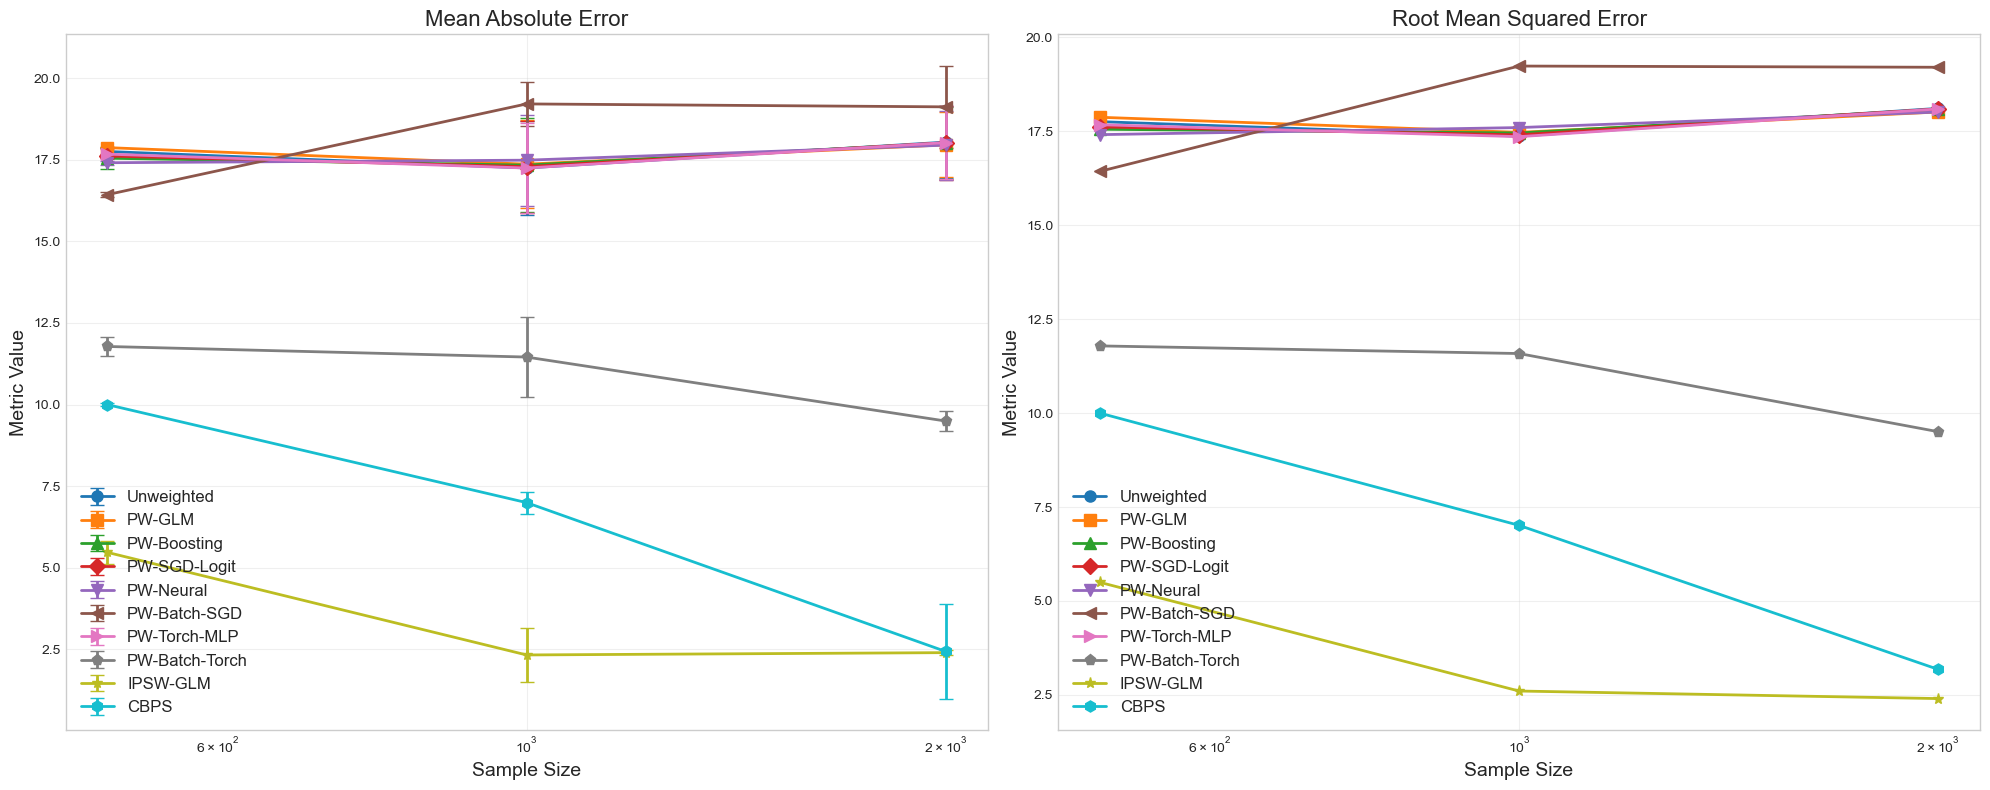

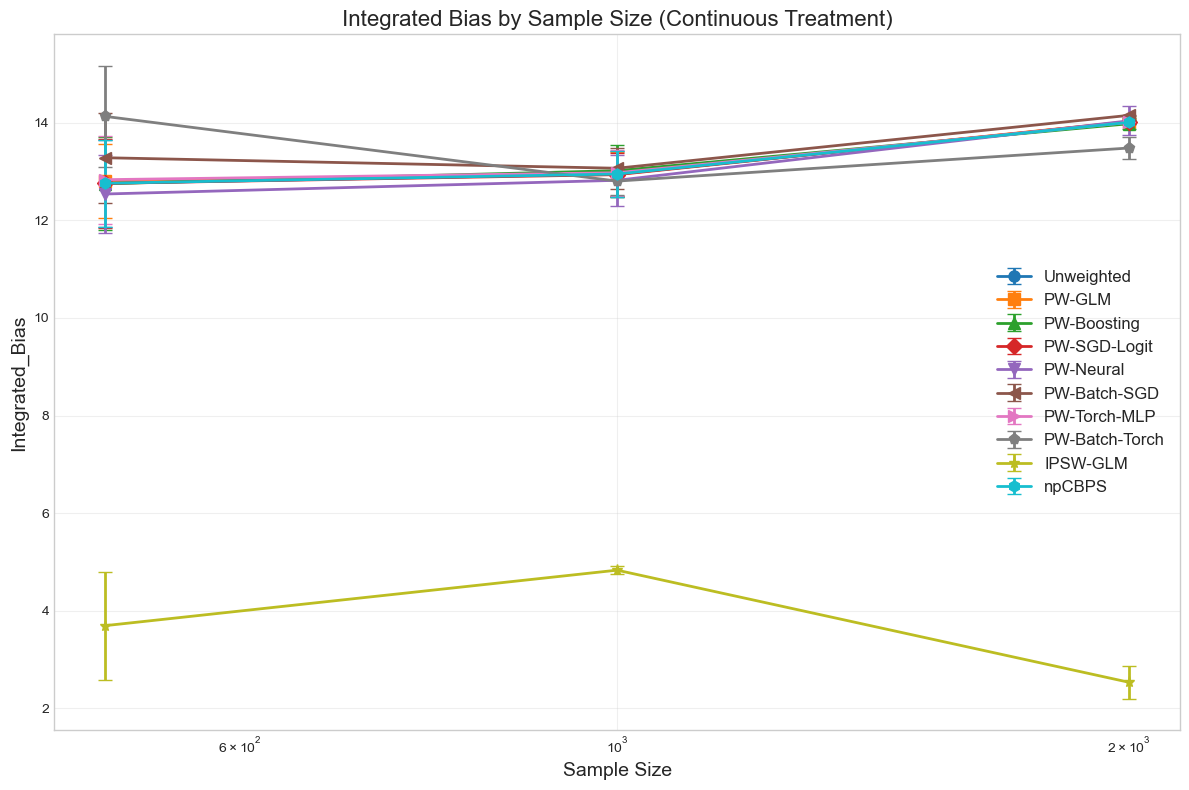

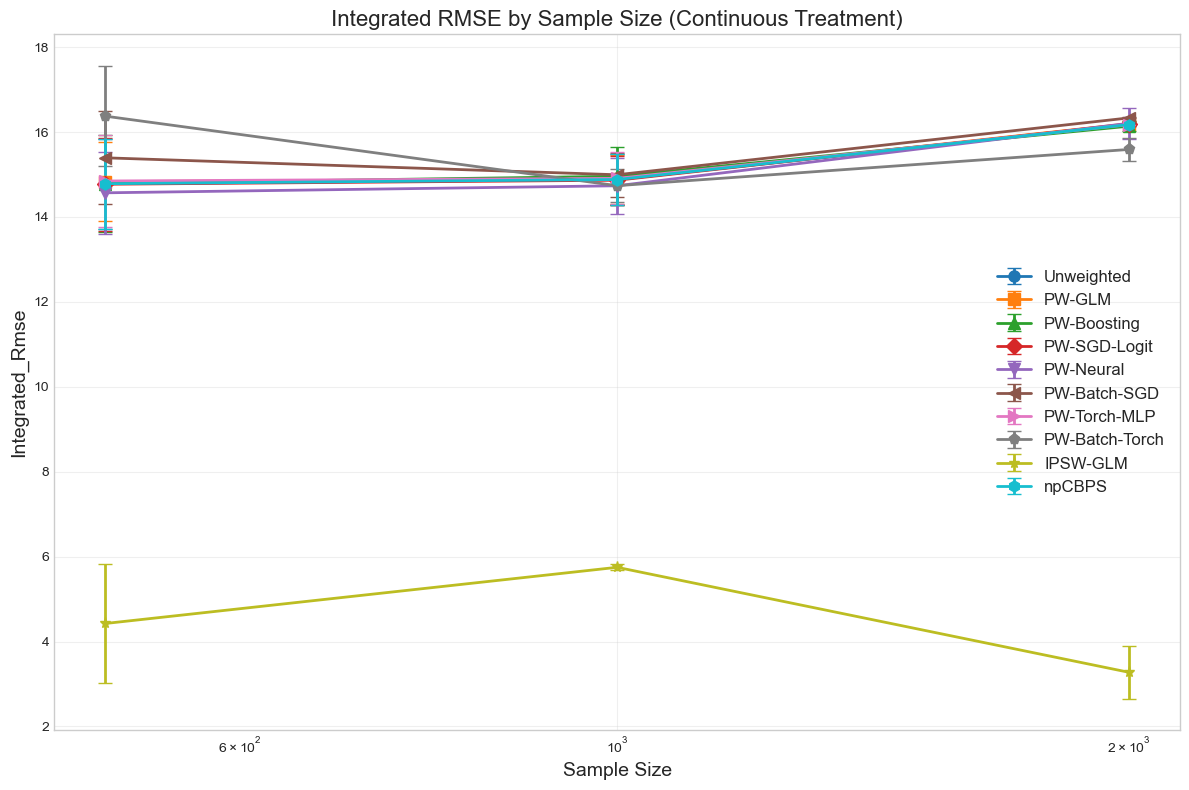

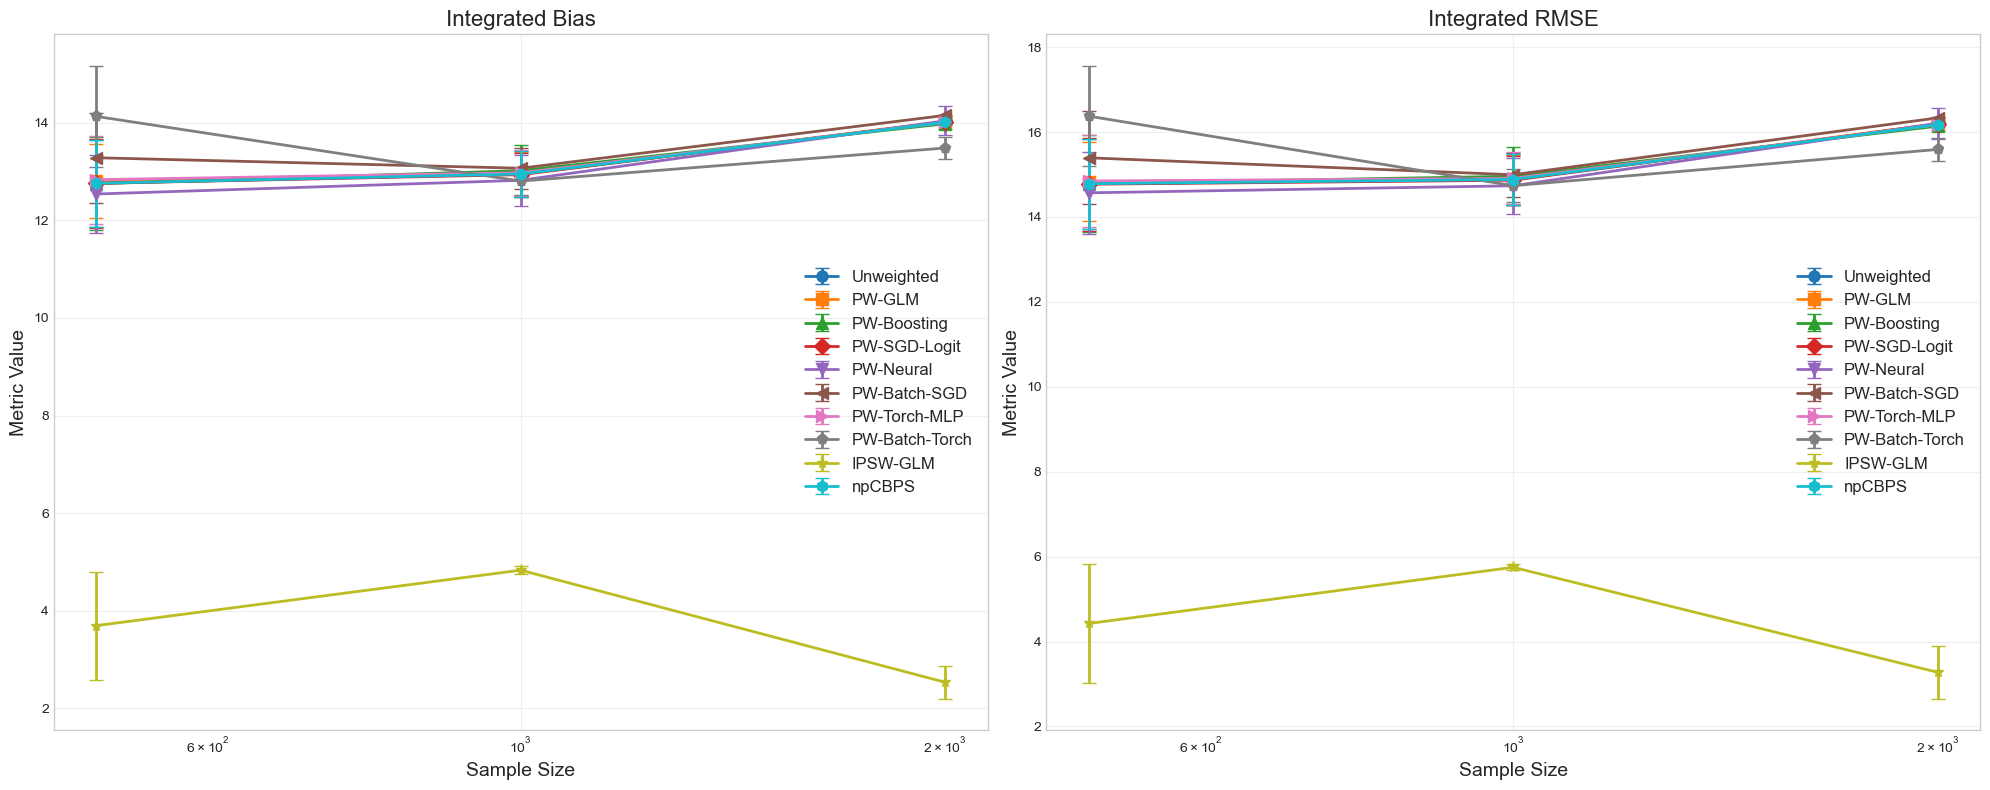

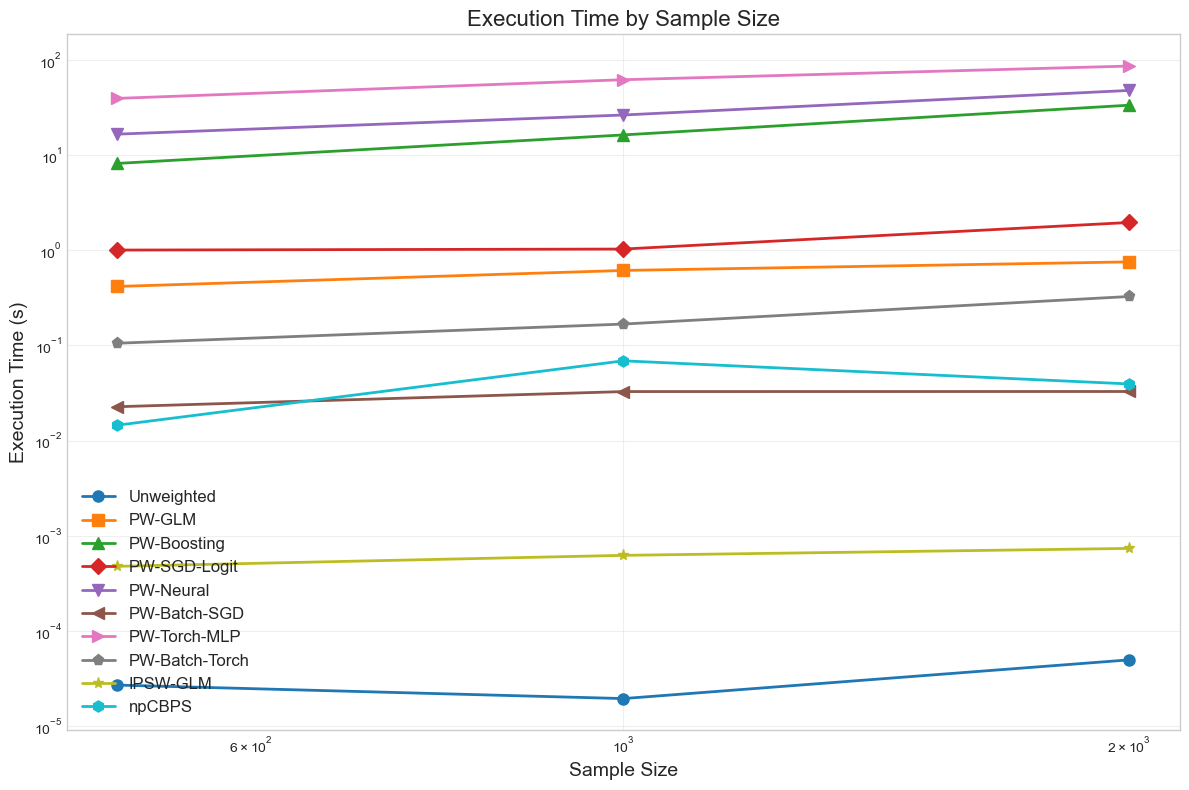

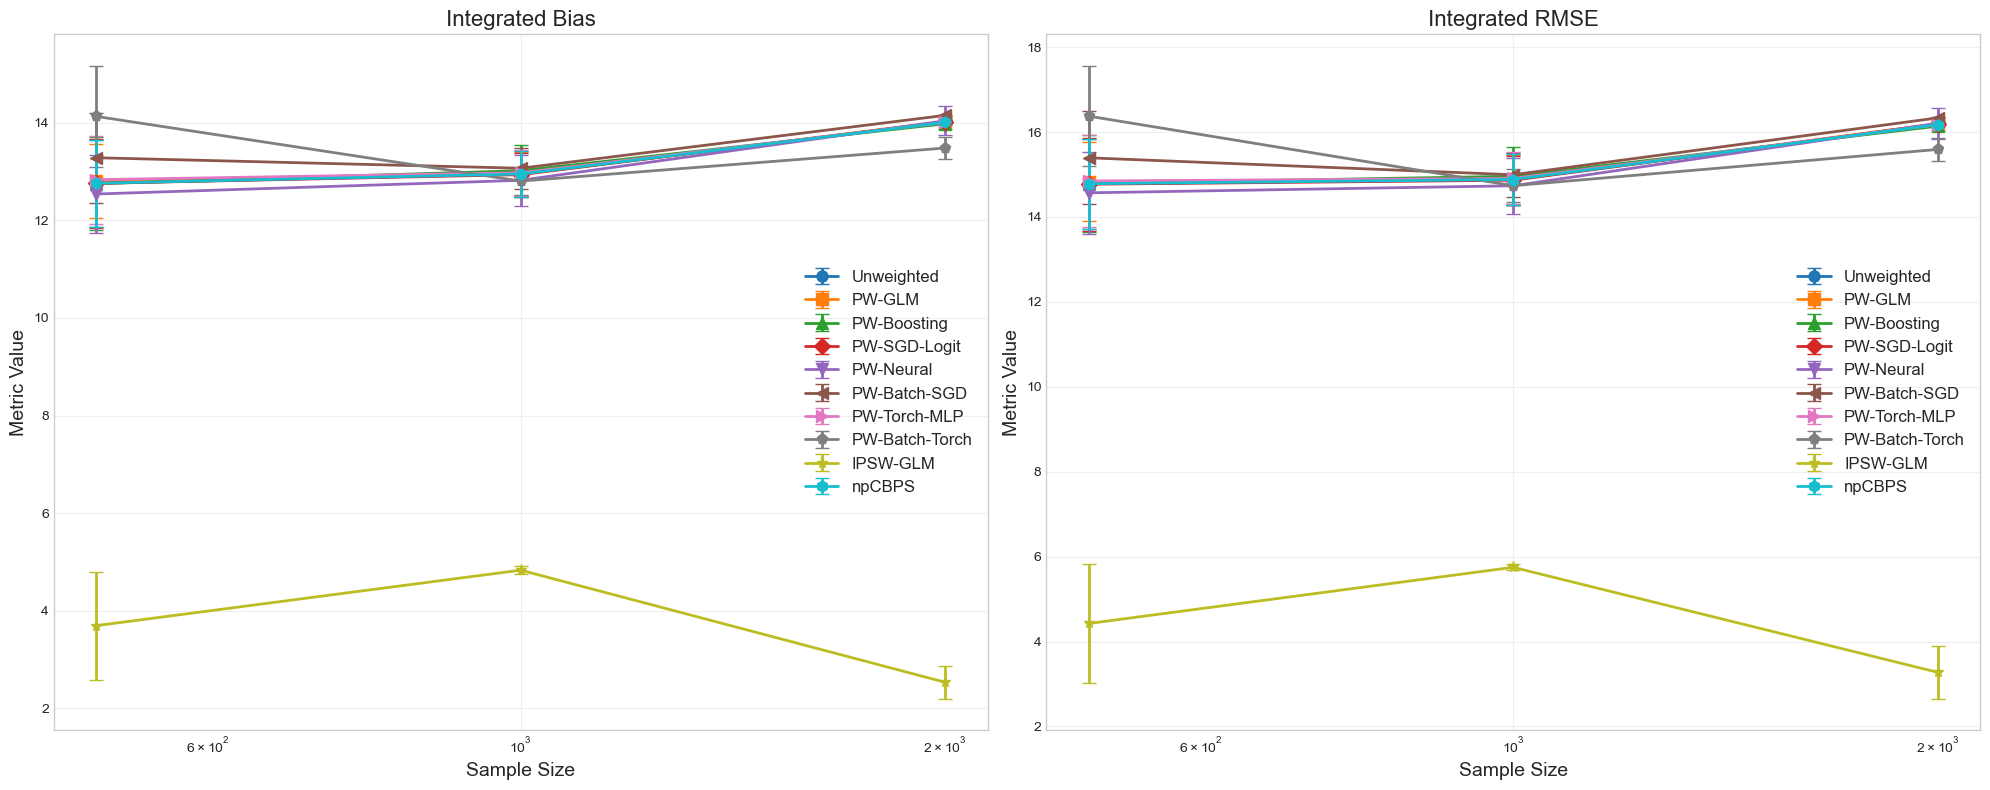

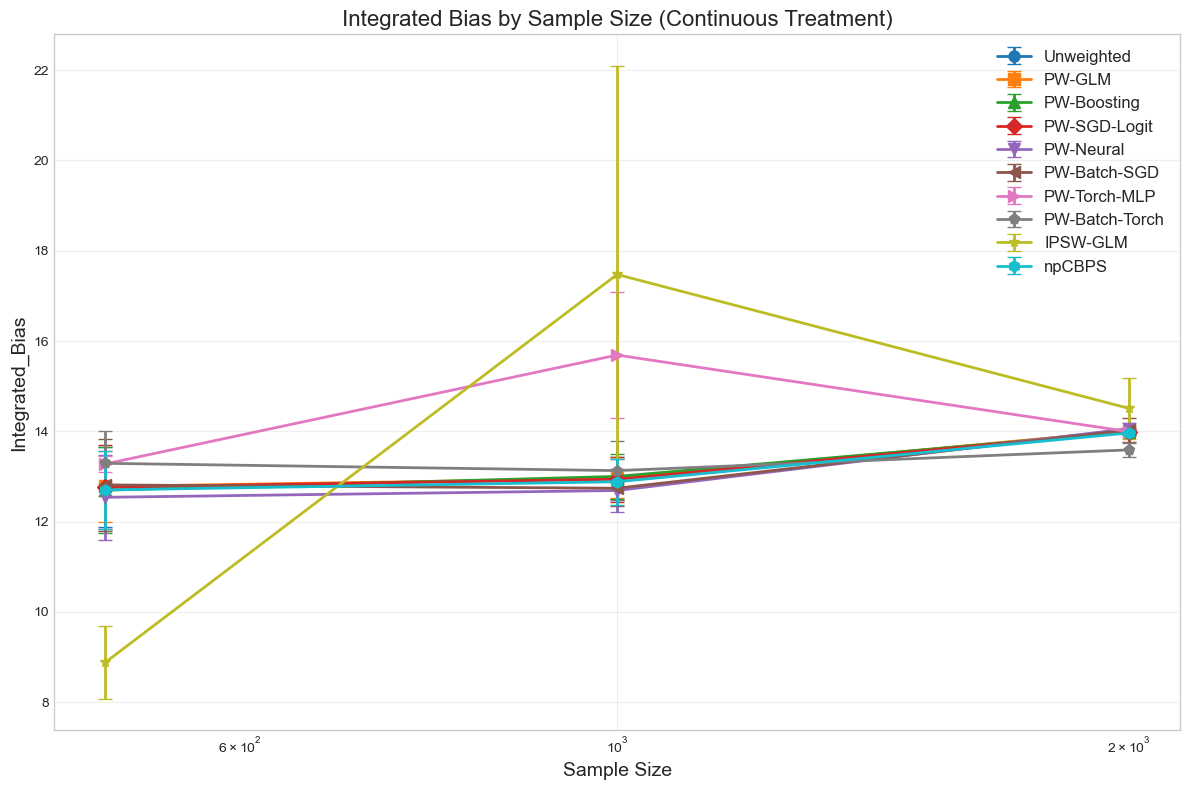

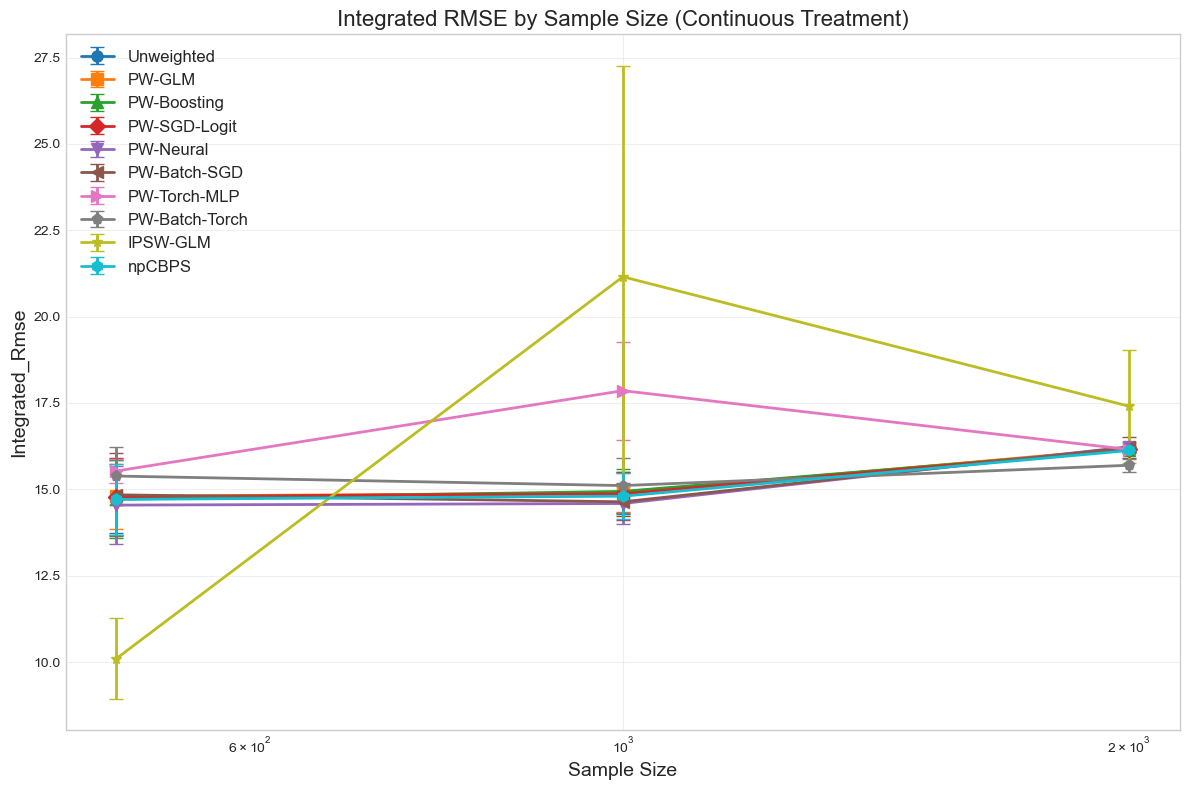

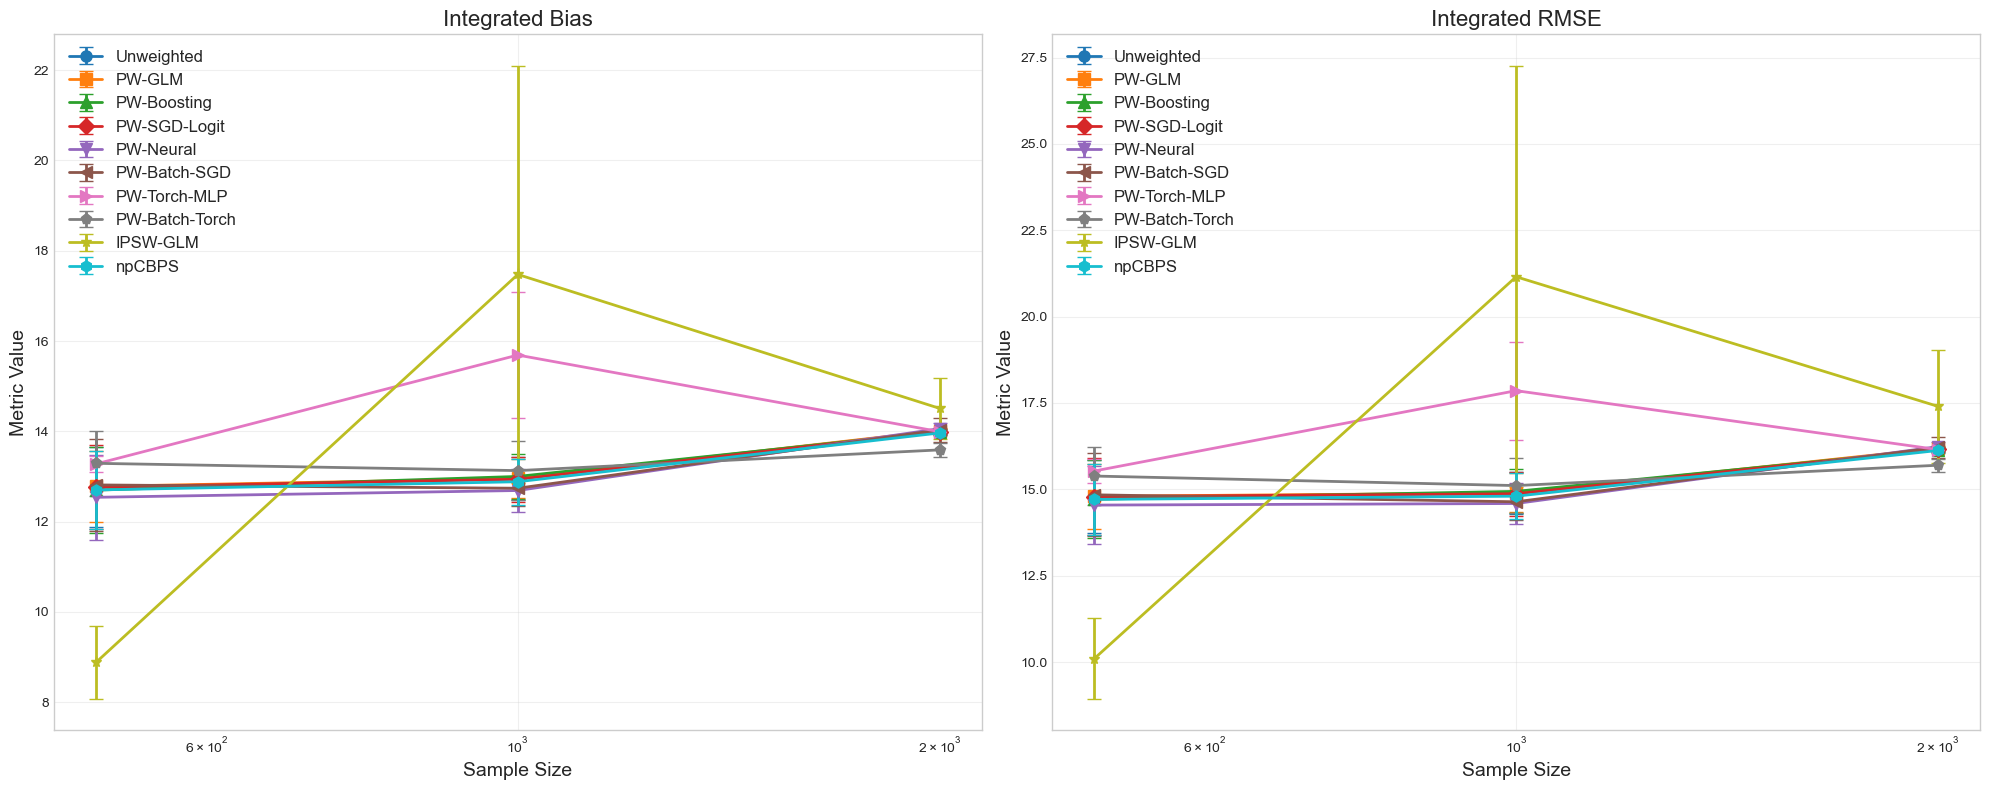

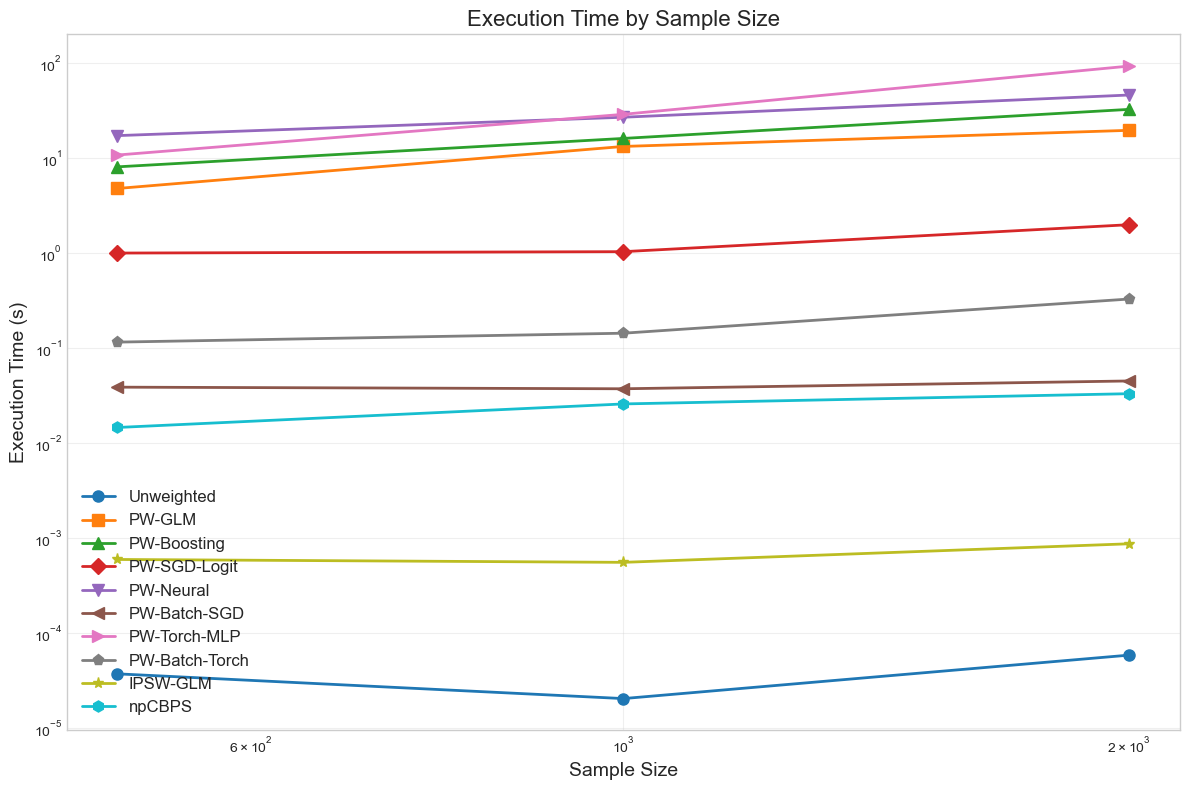

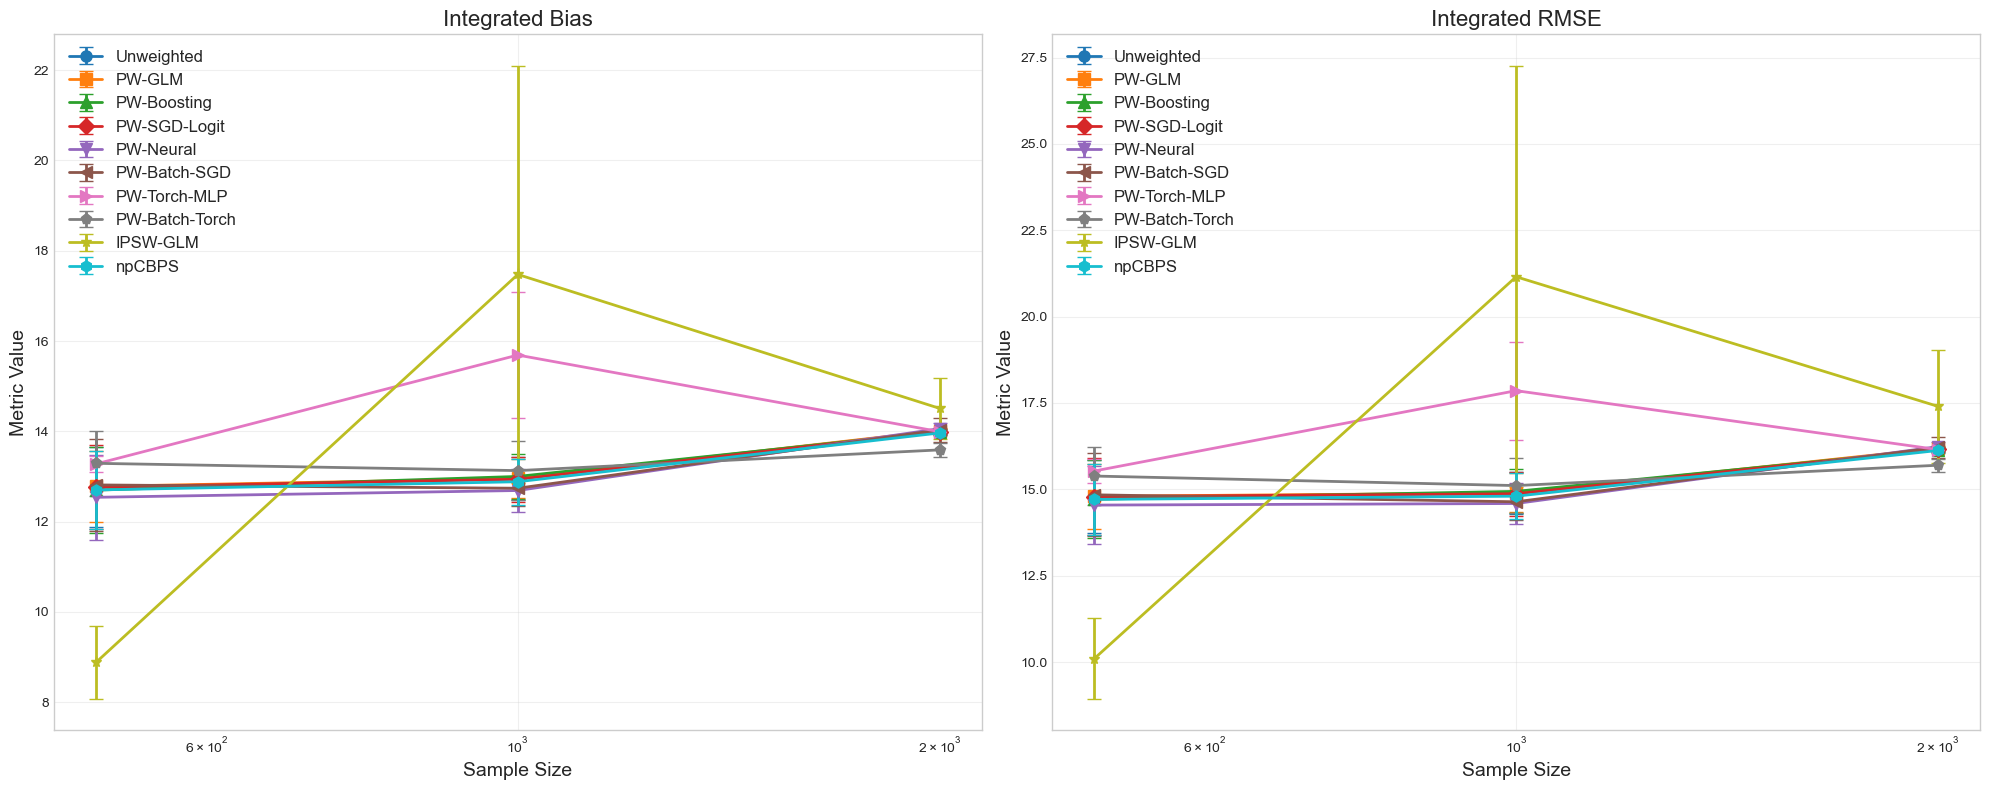

In [4]:
# Main function for model comparison notebook
def main_model_comparison():
    """
    Main function to run model comparison simulations for permutation weighting
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from datetime import datetime
    import multiprocessing
    
    from examples.data_utils import create_output_dir
    
    # Create main output directory
    main_output_dir = create_output_dir("model_comparison")
    print(f"Main results will be saved to: {main_output_dir}")
    
    # Determine max workers based on system - use fewer than total cores for stability
    max_workers = max(1, min(8, multiprocessing.cpu_count() - 1))
    print(f"Using sequential processing for simulations due to pickling limitations")
    
    # Define sample sizes - use smaller sample sizes for faster testing
    sample_sizes = [500, 1000, 2000]
    
    n_replications = 2  # Reduced for faster testing
    
    max_workers= 8 
    # Neural network configurations
    nn_configs = {
        'hidden_size': 64,
        'batch_size': 32,  # Used for internal mini-batch optimization
        'epochs': 100, # Used  as may iter 
        'learning_rate': 0.001,
        'alpha': 0.0001,
        
    }
    
    # Check if PyTorch is available
    torch_available = False
    try:
        import torch
        torch_available = True
        print("PyTorch is available. Will include PyTorch models.")
    except ImportError:
        print("PyTorch not available, skipping PyTorch-based models")
    
    # Define methods to include
    core_methods = ['Unweighted', 'IPSW-GLM', 'PW-GLM', 'PW-Boosting']
    sgd_methods = ['PW-SGD-Logit', 'PW-Neural', 'PW-Batch-SGD']
    torch_methods = [] if not torch_available else ['PW-Torch-MLP', 'PW-Batch-Torch']
    
    # For faster testing, use fewer methods
    binary_methods = core_methods + ['CBPS'] + sgd_methods+ torch_methods
    continuous_methods = core_methods + ['npCBPS'] + sgd_methods+ torch_methods
    
    # Configure simulation runs
    simulation_configs = [
        {
            'title': "Binary Treatment (Well-Specified)",
            'continuous_treatment': False,
            'misspecified': False,
            'methods_to_include': binary_methods,
            'output_dir': os.path.join(main_output_dir, "binary_wellspec"),
            'n_replications': n_replications
        },
        {
            'title': "Binary Treatment (Misspecified)",
            'continuous_treatment': False,
            'misspecified': True,
            'methods_to_include': binary_methods,
            'output_dir': os.path.join(main_output_dir, "binary_misspec"),
            'n_replications': n_replications
        },
        {
            'title': "Continuous Treatment (Well-Specified)",
            'continuous_treatment': True,
            'misspecified': False,
            'methods_to_include': continuous_methods,
            'output_dir': os.path.join(main_output_dir, "continuous_wellspec"),
            'n_replications': n_replications
        },
        {
            'title': "Continuous Treatment (Misspecified)",
            'continuous_treatment': True,
            'misspecified': True,
            'methods_to_include': continuous_methods,
            'output_dir': os.path.join(main_output_dir, "continuous_misspec"),
            'n_replications': n_replications
        }
    ]
    
    # Run all simulations
    for i, config in enumerate(simulation_configs):
        print(f"\n=== Running Simulation {i+1}/{len(simulation_configs)}: {config['title']} ===")
        
        raw_results, summary = run_simulation(
            n_replications=config['n_replications'],
            sample_sizes=sample_sizes,
            misspecified=config['misspecified'],
            continuous_treatment=config['continuous_treatment'],
            nn_configs=nn_configs,
            methods_to_include=config['methods_to_include'],
            output_dir=config['output_dir'],
            max_workers= max_workers,  # Force sequential processing
            verbose=True
        )
        
        print(f"Simulation {i+1} complete. Results saved to {config['output_dir']}")
    
    print(f"\nAll simulations complete. Results saved to '{main_output_dir}' directory.")

if __name__ == "__main__":
    main_model_comparison()